# "COVID-19 - Dashboard overview"
> Or maybe a poster generator for the macabre data junkie, updated daily

- comments: true
- author: Caglar Cakan
- categories: [covid19]
- permalink: /covid-dashboard/
- image: images/icon_covid_dashboard.png
- license: Creative Commons

In [1]:
#hide_input
import datetime
print("This page was last built on", datetime.datetime.now().strftime("%d.%m.%y %H:%M:%S"))

This page was last built on 13.05.20 01:10:01


**Colors:** 
If the last reported cases are < 25% of the maximum, the data is shown in green. Else, if the last cases are > 75% of the maximum, the data is shown in red. Else, grey.

**Axes:** 
The data is shown on a **normalized y-axis**. This means that the actual numbers between countries can be very different and should not be compared. On the x-axis, the data is shown from the day of the 100th positive case until today.

**Preprocessing:**
The number of new cases per day is averaged using a 10-day rolling window. Countries are included if they have at least 1000 cases and at least 100 deaths. Countries are sorted by total number of cases. 

**Data:** The data is pulled from the COVID-19 [Data Repository](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series) by Johns Hopkins CSSE

**Versions:**
* [Color neural](https://caglorithm.github.io/notebooks/images/covid-dashboard/neutral.png) version for folks who prefer other colors than red and green
* [Alphabetically sorted](https://caglorithm.github.io/notebooks/images/covid-dashboard/sorted.png)
* [Larger version](https://caglorithm.github.io/notebooks/images/covid-dashboard/large.png) with less filtering and **many more countries**
* [Large color neutral](https://caglorithm.github.io/notebooks/images/covid-dashboard/large-neutral.png)

In [2]:
#hide
import numpy as np

import datetime

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates

import requests
import io
import math

from countryinfo import CountryInfo

In [3]:
#hide
import matplotlib
matplotlib.rc_file('mplstyles/dark.mplstyle')

In [4]:
#hide
import lib.covid_data as cd

In [5]:
#hide
def make_plot(dff, countries, colors=None, dpi=300, ncols=5, savename=None, show=True, hpad=0):
    ROLLING_MEAN_DAYS = 10
    nrows = math.ceil(len(countries)/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*1.5, nrows*1.5), dpi=dpi)
    plt.tight_layout(h_pad=hpad, w_pad=-2, )

    for i, str_country in enumerate(countries):
        df_cases_country = dff2[dff2['country']==str_country]      

        r = int(i / ncols)
        c = i % ncols
        axs = ax[r, c]


        #axs.bar(df_cases_country.index, df_cases_country.new_confirmed, lw=4, label=f"Confirmed cases", color='k')
        rolling_mean = df_cases_country.new_confirmed.rolling(ROLLING_MEAN_DAYS).mean()

        color_white = "#AAAAAA"
        color = color_white
        last_cases = rolling_mean.iloc[-1]
        last_ratio = last_cases/rolling_mean.max()
        #print(f"{str_country}: {100*last_ratio:.2f} % (max: {df_cases_country.new_confirmed.max()}, last: {last_cases})")

        if last_ratio < 0.25:
            color='springgreen'
            if colors=='muted':
                color='C1'            
        elif last_ratio > 0.75:
            color='red'
            if colors=='muted':
                color='C4'            

        axs.set_title(f"{str_country}", size=12, pad=3, color=color_white)
        axs.plot(df_cases_country.index, rolling_mean, lw=2, label=f"Confirmed cases", color=color)

        axs.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every x months
        axs.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y')) 


    # turn off axis
    for r in range(nrows):
        for c in range(ncols):
            ax[r, c].axis('off')

    import matplotlib
    bob = matplotlib.transforms.Bbox([[0.5, ncols-3.2], [4.7, ncols-0.16]])
    
    if savename:
        plt.savefig(f"../images/covid-dashboard/{savename}.png", bbox_inches="tight")
    if show:
        plt.show();
    else:
        plt.close(fig)

# Countries sorted by total cases

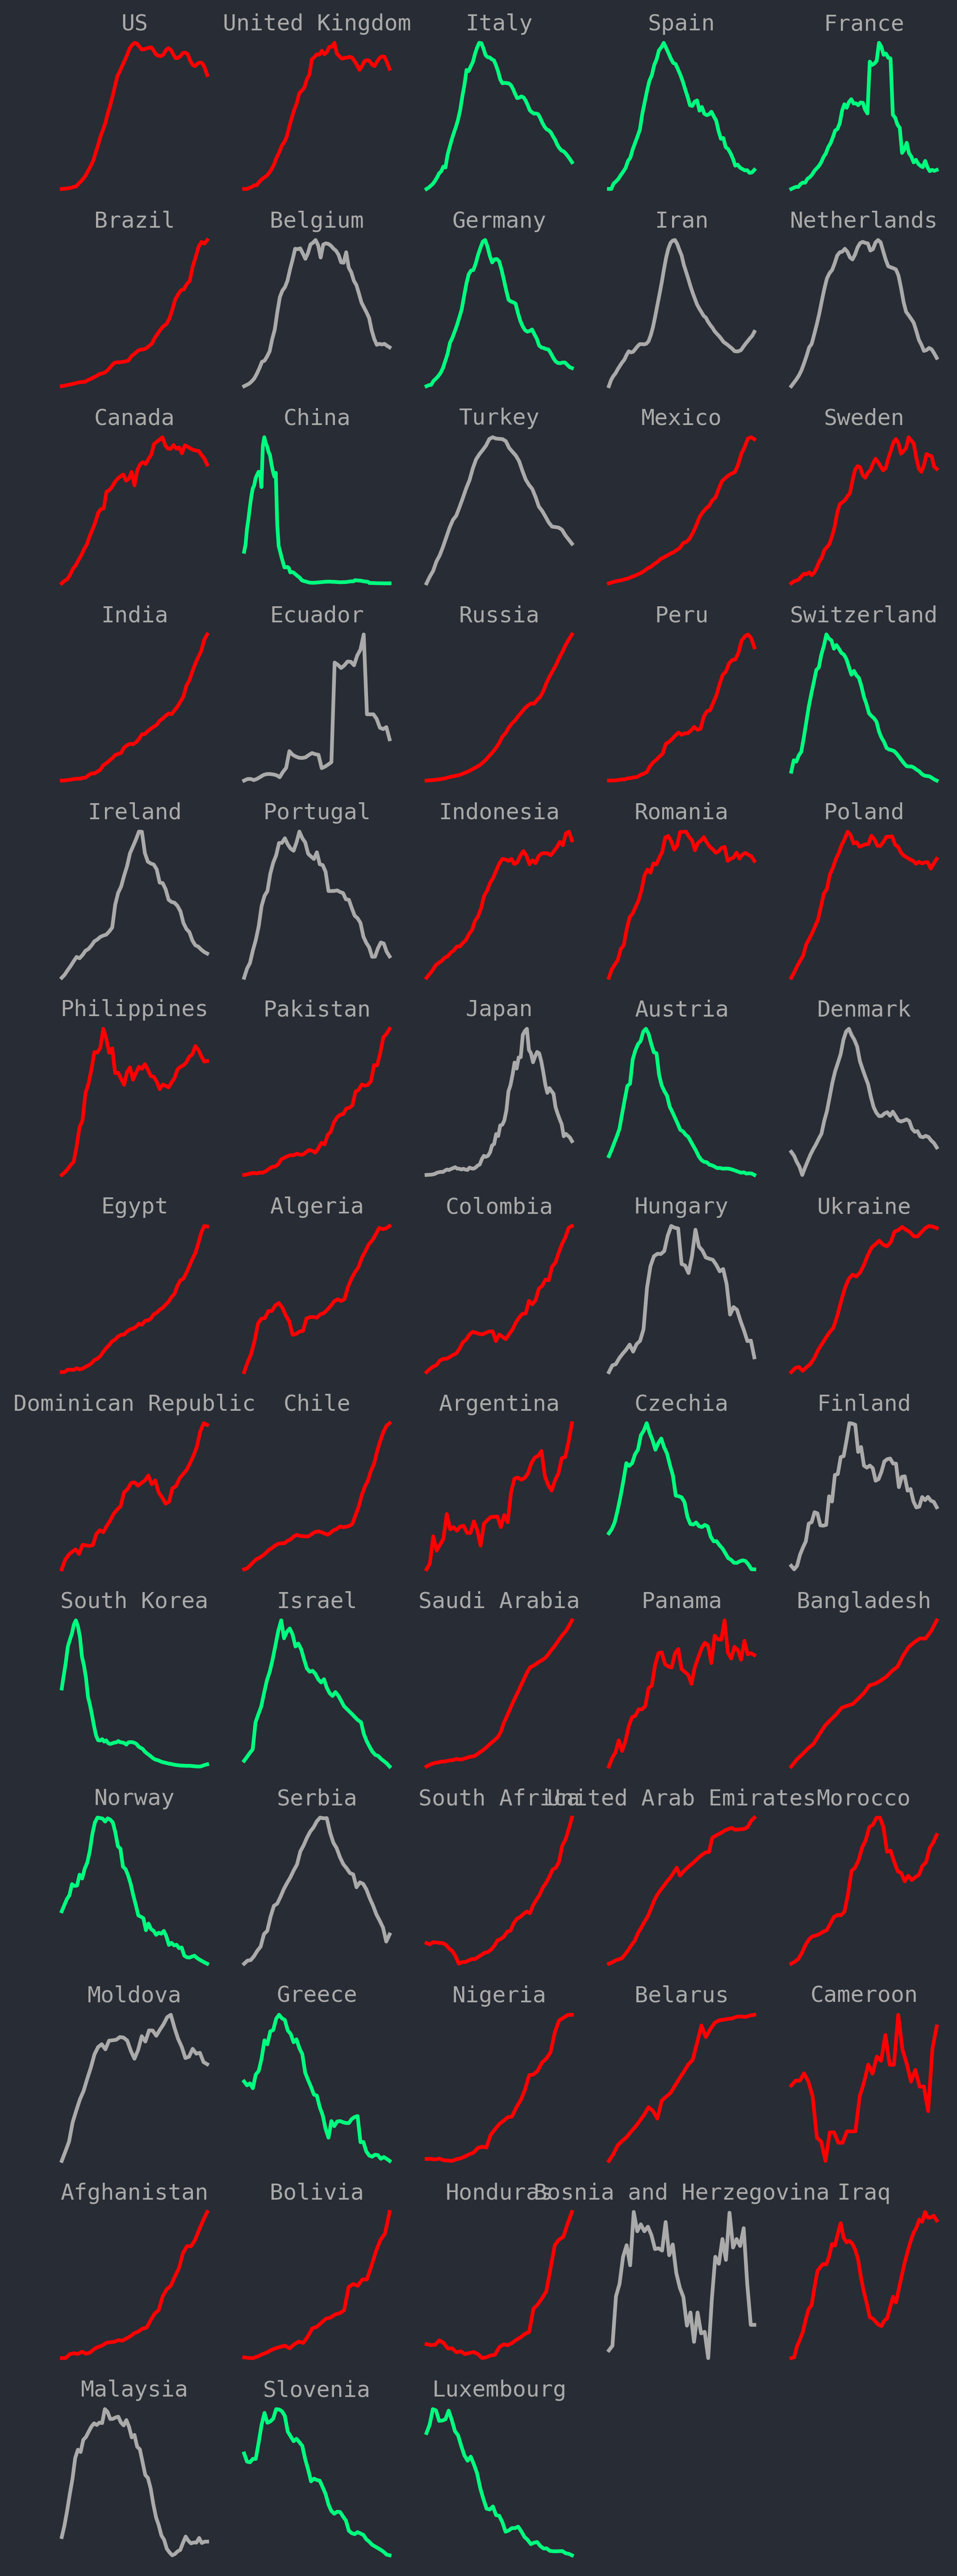

In [6]:
#hide_input
dff2 = cd.get_df(MIN_CASES = 1000, SINCE_CASES = 100)
countries = cd.get_countries_with_min_cases(dff2, 'deaths', min_cases= 100)
make_plot(dff2, countries, savename="dashboard")

# Large overview

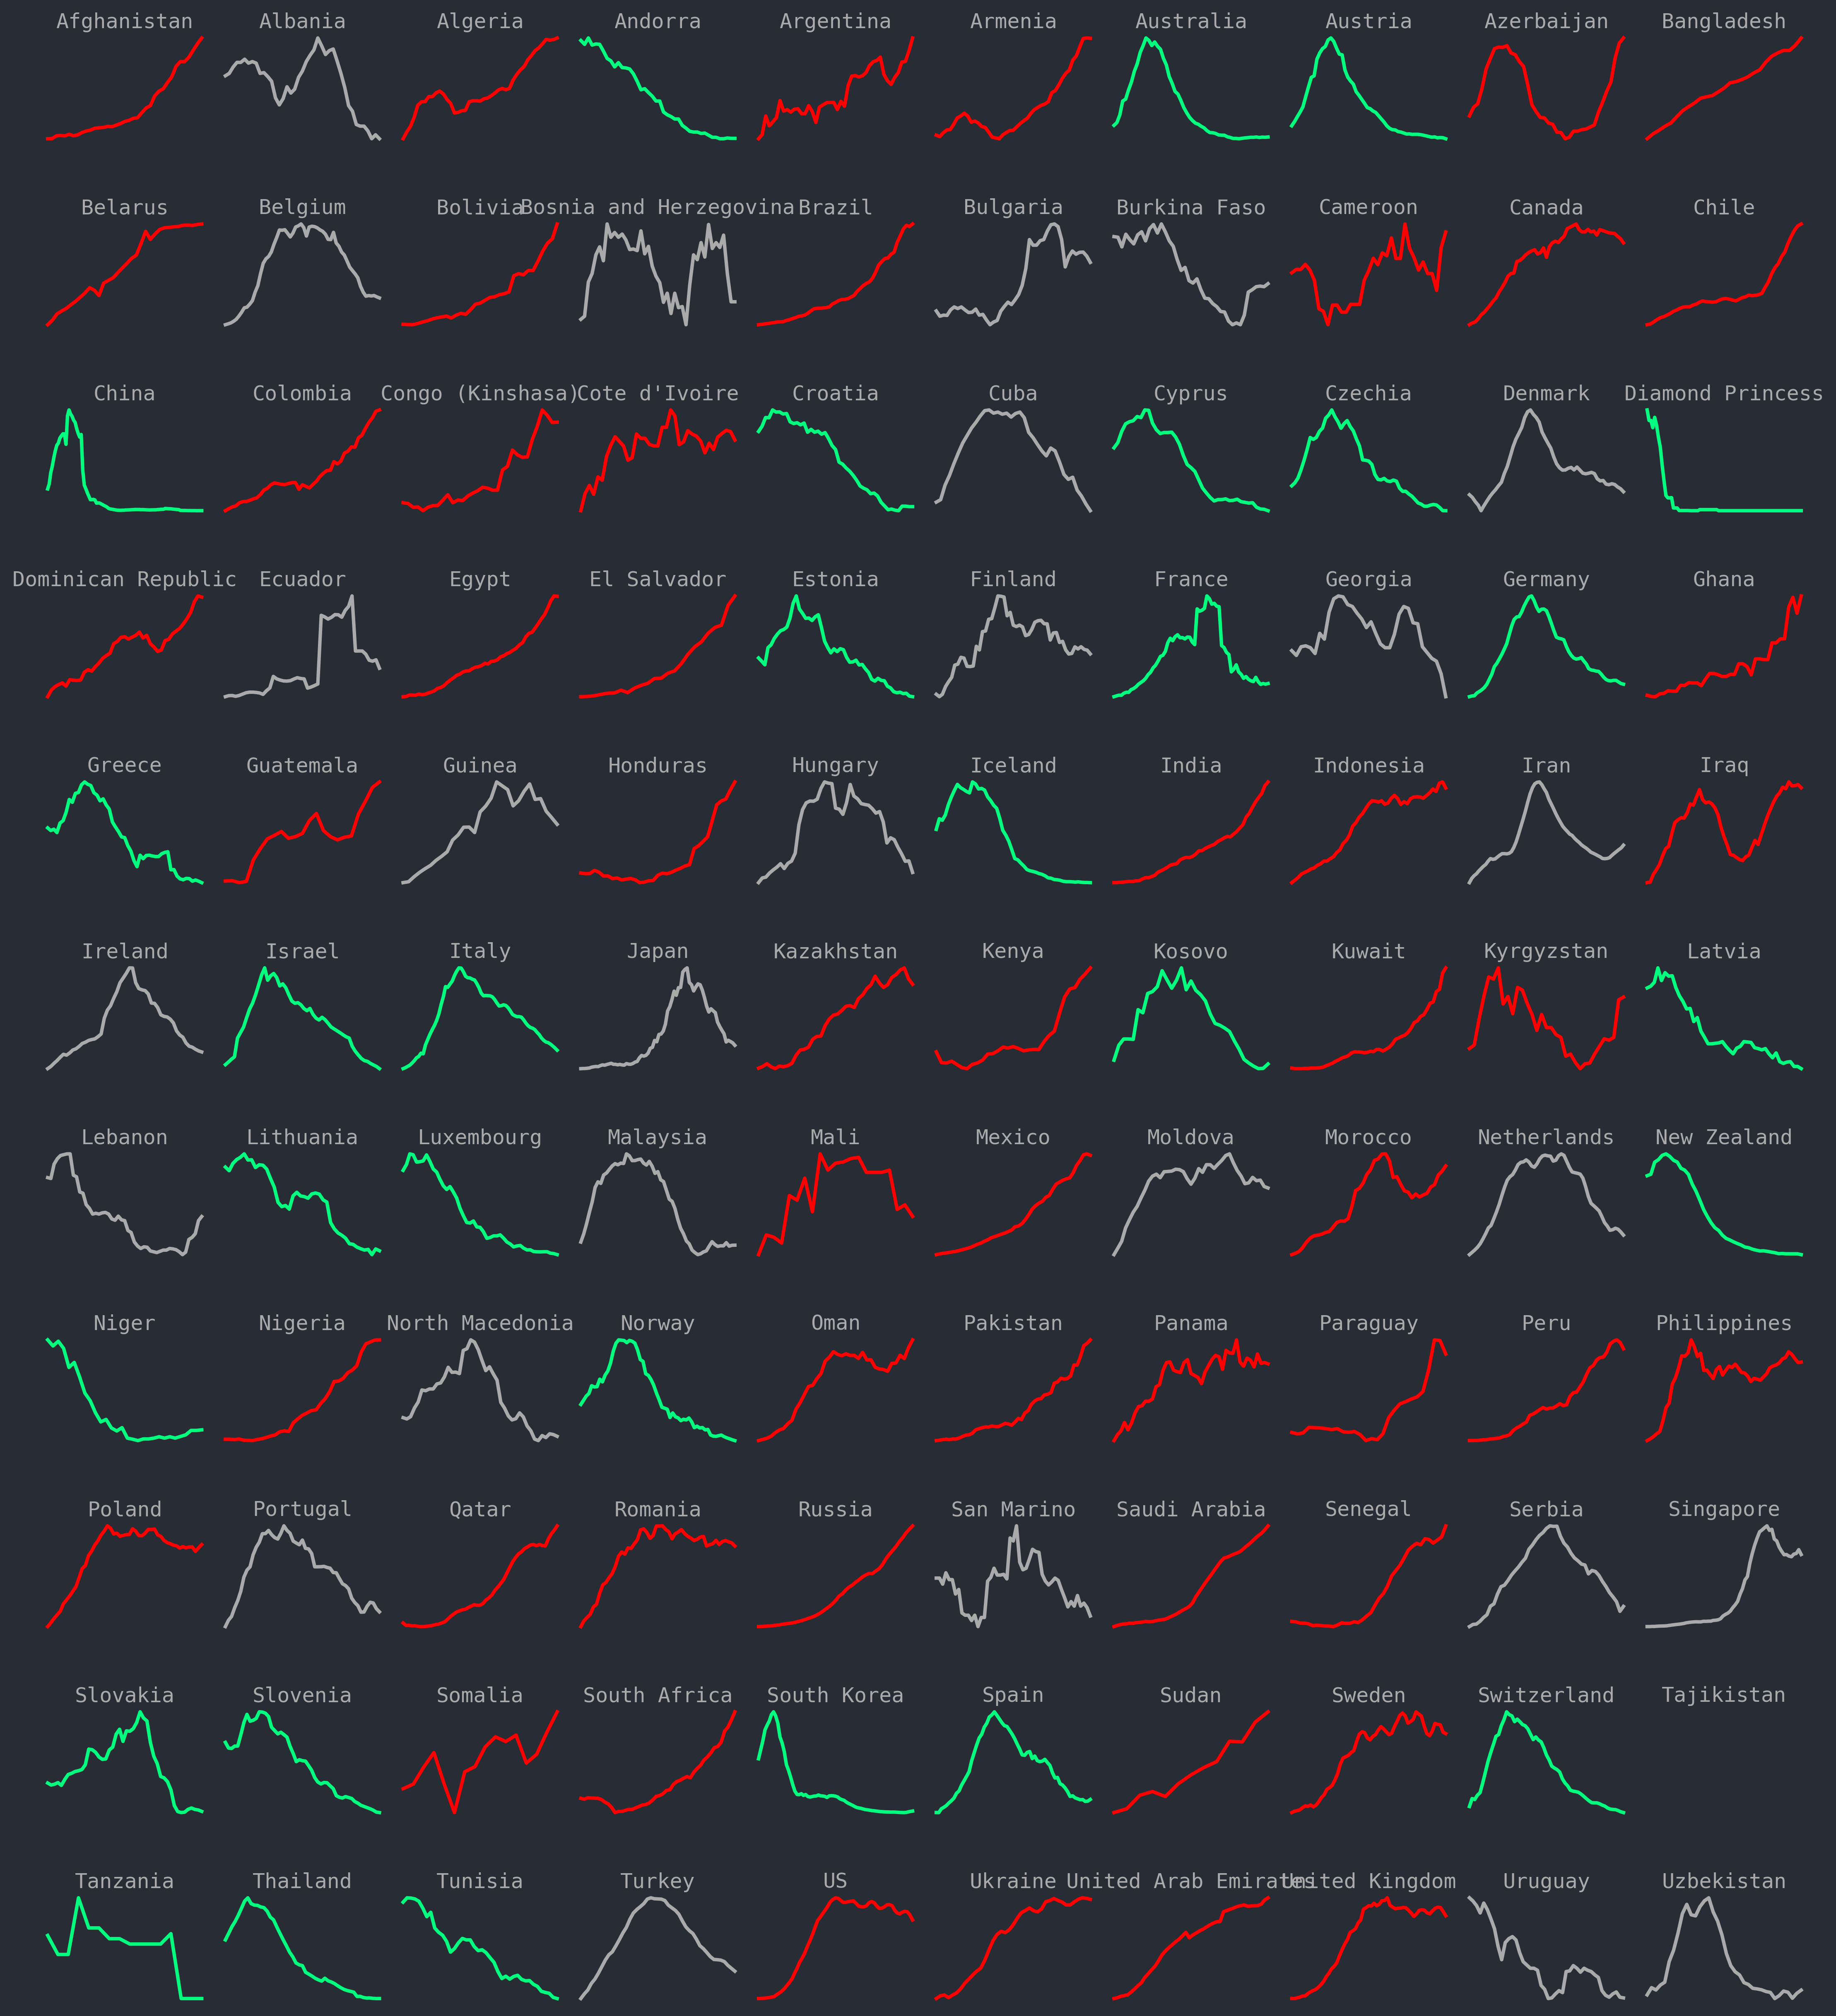

In [7]:
#hide_input
dff2 = cd.get_df(MIN_CASES = 500, SINCE_CASES = 100)
countries = cd.get_countries_with_min_cases(dff2, 'deaths', min_cases= 10)
countries.sort()
make_plot(dff2, countries, ncols=10, savename='large', show=True, hpad=2)

In [8]:
#hide
#code for generating alternative versions

In [9]:
#hide
dff2 = cd.get_df(MIN_CASES = 1000, SINCE_CASES = 100)
countries = cd.get_countries_with_min_cases(dff2, 'deaths', min_cases= 100)
countries.sort()
make_plot(dff2, countries, savename='sorted', show=False)

In [10]:
#hide
dff2 = cd.get_df(MIN_CASES = 1000, SINCE_CASES = 100)
countries = cd.get_countries_with_min_cases(dff2, 'deaths', min_cases= 100)
make_plot(dff2, countries, savename='neutral', show=False, colors='muted')

In [11]:
#hide_input
dff2 = cd.get_df(MIN_CASES = 500, SINCE_CASES = 100)
countries = cd.get_countries_with_min_cases(dff2, 'deaths', min_cases= 10)
countries.sort()
make_plot(dff2, countries, ncols=10, savename='large-neutral', show=False, colors='muted', hpad=2)